In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq

from google.colab import drive
drive.mount('/content/drive')

out_filename = '/content/drive/My Drive/Colab Notebooks/stanovi_data.csv'

BAR_COLOR = '#e66707'
BAR_COLOR_2 = '#5aa913'
BAR_COLOR_3 = '#c03548'
TICK_COLOR = '#000000'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title
# Data scraping
headers = "cena,kvadratura,cena/m2,opstina,lokacija,broj_soba\n"
f = open(out_filename, "w")
f.write(headers)

for i in range(1,382):
    page_url = "https://www.halooglasi.com/nekretnine/prodaja-stanova/beograd?page=" + str(i)
    uClient = uReq(page_url)
    page_soup = soup(uClient.read(), "html.parser")
    containers = page_soup.findAll("div", {"class": "col-md-12 col-sm-12 col-xs-12 col-lg-12"})
    for container in containers:
        # make_rating_sp = container.div.select("a")
        # brand = make_rating_sp[0].img["title"].title()
        # product_name = container.div.select("a")[2].text
        # shipping = container.findAll("li", {"class": "price-ship"})[0].text.strip().replace("$", "").replace(" Shipping", "")
        # f.write(brand + ", " + product_name.replace(",", "|") + ", " + shipping + "\n")

        cena = container.div.div("div", {"class": "central-feature"})[0].find("span").text
        cena = cena[0:(len(cena)-2)].replace(",", ".").replace(".", "")
        cena_po_kvad = container.div.div("div", {"class": "price-by-surface"})[0].find("span").text
        cena_po_kvad = cena_po_kvad[0:(len(cena_po_kvad)-5)].replace(",", ".").replace(".", "")

        tmp_cont = container.div.div("div", {"class": "col-md-6 col-sm-5 col-xs-6 col-lg-6 sm-margin"})[0].find("ul", {"class": "subtitle-places"}).findAll("li")
        opstina = tmp_cont[1].text
        opstina = opstina[8:len(opstina)]
        lokacija = tmp_cont[2].text

        tmp_cont = container.div.div("div", {"class": "col-md-6 col-sm-5 col-xs-6 col-lg-6 sm-margin"})[0].find("ul", {"class": "product-features"}).findAll("li")
        kvadratura = tmp_cont[0].div.text
        kvadratura = kvadratura[0:len(kvadratura)-13].replace(",", ".")
        broj_soba = tmp_cont[1].div.text
        broj_soba = broj_soba[0:len(broj_soba)-10]
        if len(tmp_cont)>2:
          spratnost = tmp_cont[2].div.text
          sprat = spratnost.split("/")[0]
        else:
          spratnost = None

        f.write(cena + "," + kvadratura + ","  + cena_po_kvad + ","  + opstina + ","  + lokacija + "," + broj_soba + "," + "\n")
    print(i)

uClient.close()
f.close()

In [47]:
df = pd.read_csv(out_filename, index_col=False)
df.describe()

,cena,kvadratura,cena/m2
count,7.611000e+03,7611.000000,7611.000000
mean,2.645195e+05,79.733139,3227.434109
std,2.179711e+05,43.419169,1279.479334
min,2.150000e+04,9.000000,97.000000
25%,1.403000e+05,54.000000,2344.000000
50%,2.100000e+05,70.000000,3024.000000
75%,3.029700e+05,94.000000,3898.500000
max,3.500000e+06,800.000000,19580.000000


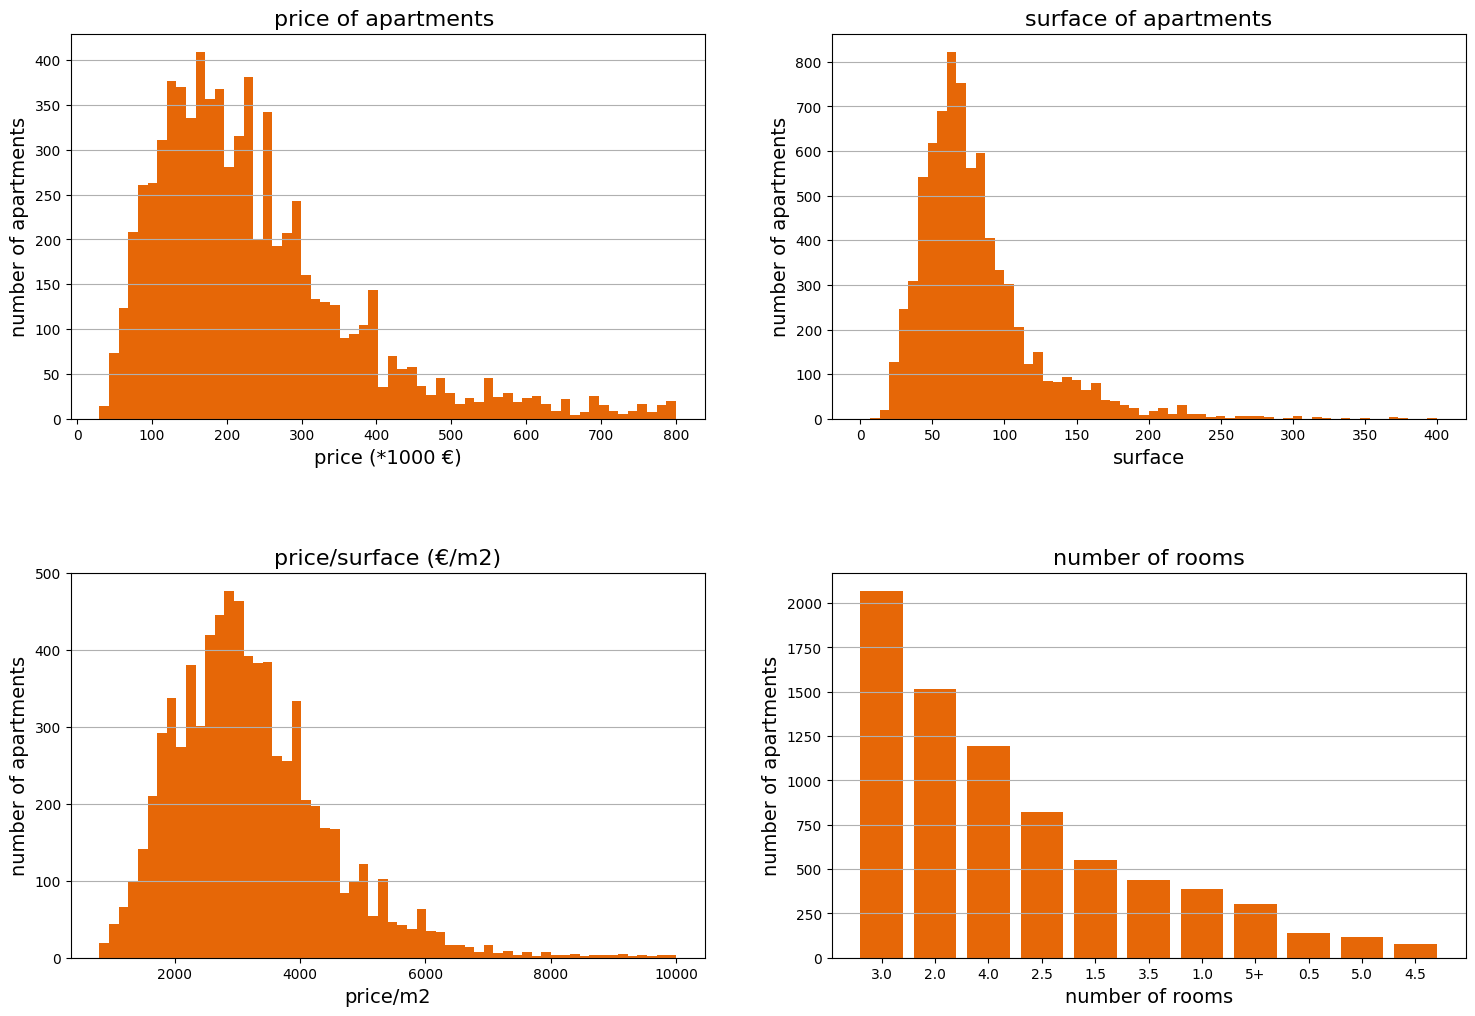

In [49]:
TITLE_FONT_SIZE= 16
LABEL_FONT_SIZE= 14

plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace = 0.4)

# distribution of price (for apartments cheaper the between min and max)
plt.subplot(221)
plt.grid(axis='y')
plt.hist(df['cena']/1000,bins=60,range=(30,800),color=BAR_COLOR)
plt.xlabel('price (*1000 €)', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.ylabel('number of apartments', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.title("price of apartments ", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
plt.rc_context({'xtick.color':TICK_COLOR, 'ytick.color':TICK_COLOR,})

# distribution of surface (for apartments with surface less then 400 m2)
plt.subplot(222)
plt.grid(axis='y')
plt.hist(df['kvadratura'],bins=60,range=(0,400),color=BAR_COLOR)
plt.xlabel('surface', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.ylabel('number of apartments', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.title("surface of apartments", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
plt.rc_context({'xtick.color':TICK_COLOR, 'ytick.color':TICK_COLOR,})

# distribution of price per surface (for apartments with price/sqm less then 8000 €/m2)
plt.subplot(223)
plt.grid(axis='y')
plt.hist(df['cena/m2'],bins=60,range=(800,10000),color=BAR_COLOR)
plt.xlabel('price/m2', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.ylabel('number of apartments', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.title("price/surface (€/m2)", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
plt.rc_context({'xtick.color':TICK_COLOR, 'ytick.color':TICK_COLOR,})

# distribution of numer of rooms
plt.subplot(224)
plt.grid(axis='y')
plt.bar(df['broj_soba'].value_counts().index,df['broj_soba'].value_counts(),color=BAR_COLOR)
plt.xlabel('number of rooms', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.ylabel('number of apartments', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.title("number of rooms", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
plt.rc_context({'xtick.color':TICK_COLOR, 'ytick.color':TICK_COLOR,})
plt.show()

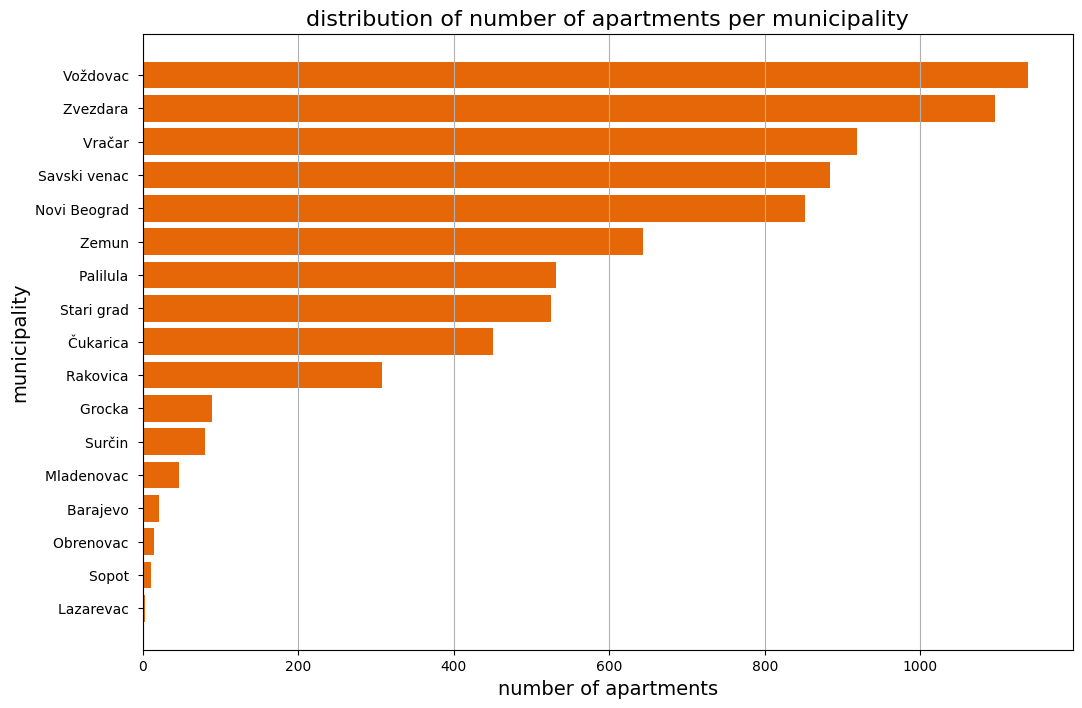

In [50]:
# distribution of number of apartmes per municipality
tmp =df['opstina'].value_counts().sort_values(ascending=True)
plt.figure(figsize=(12, 8))
plt.grid(axis='x')
plt.barh(tmp.index, tmp, color=BAR_COLOR)
plt.xlabel('number of apartments', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.ylabel('municipality', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.title("distribution of number of apartments per municipality", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
plt.rc_context({'xtick.color':TICK_COLOR, 'ytick.color':TICK_COLOR,})
plt.show()

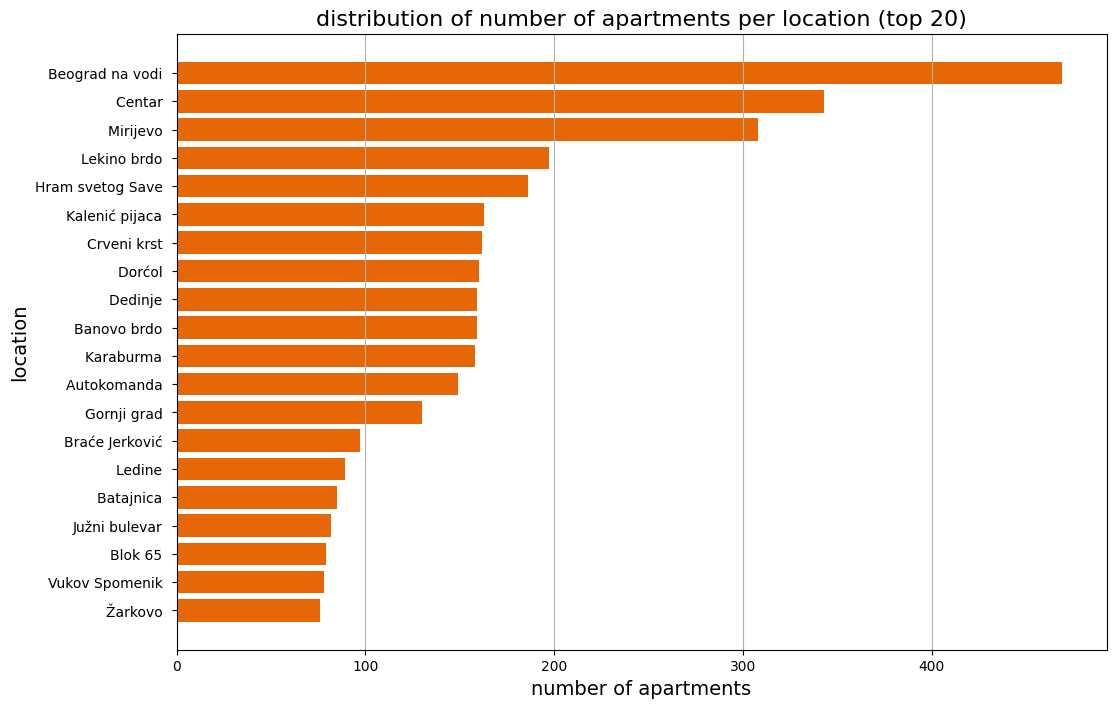

In [51]:
# distribution of number of apartmes per location (top 20 locations)
tmp =df['lokacija'].value_counts().sort_values(ascending=False)[0:20].sort_values(ascending=True)
plt.figure(figsize=(12, 8))
plt.grid(axis='x')
plt.barh(tmp.index, tmp, color=BAR_COLOR)
plt.xlabel('number of apartments', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.ylabel('location', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.title("distribution of number of apartments per location (top 20)", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
plt.rc_context({'xtick.color':TICK_COLOR, 'ytick.color':TICK_COLOR,})
plt.show()

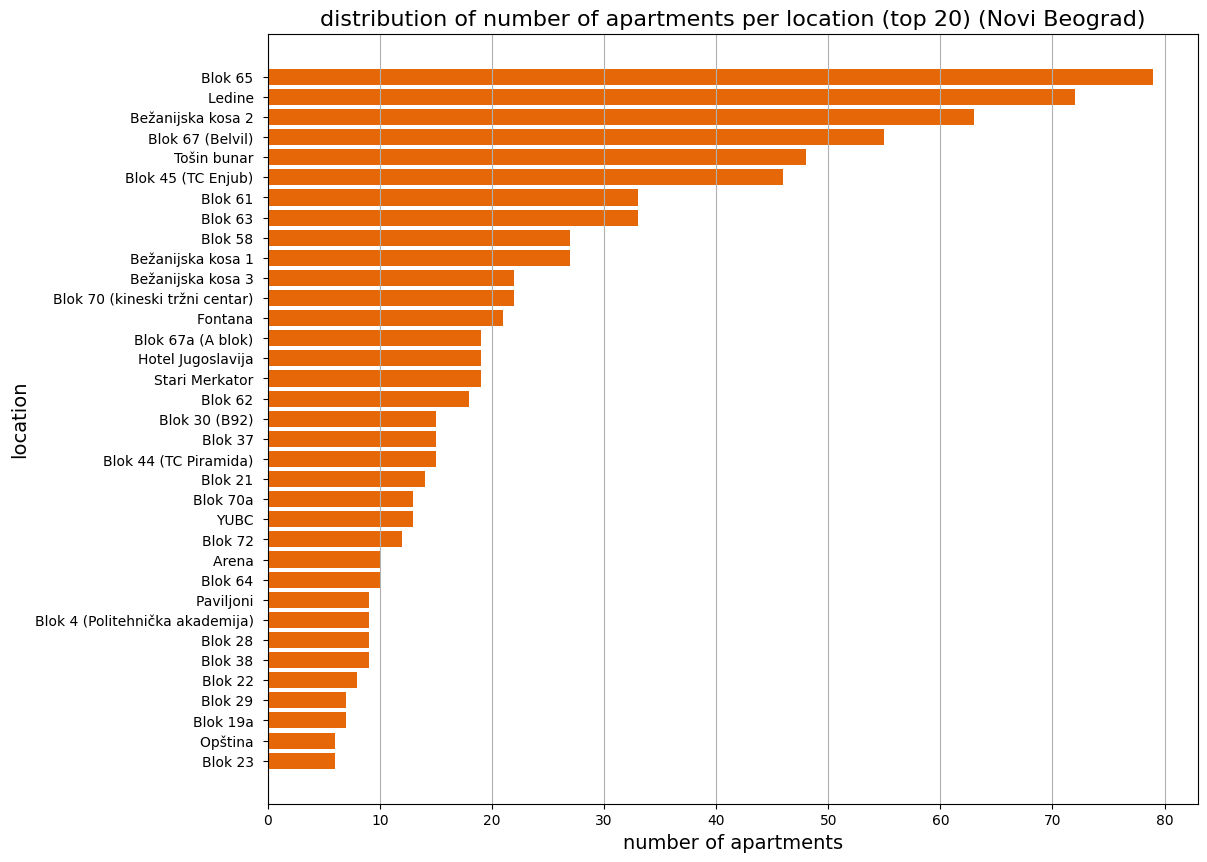

In [69]:
# distribution of number of apartmes per location, Novi Beograd (top 50 locations)
tmp =df[df['opstina'] == 'Novi Beograd ']['lokacija'].value_counts().sort_values(ascending=False)[0:35].sort_values(ascending=True)
plt.figure(figsize=(12, 10))
plt.grid(axis='x')
plt.barh(tmp.index, tmp, color=BAR_COLOR)
plt.xlabel('number of apartments', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.ylabel('location', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.title("distribution of number of apartments per location (top 20) (Novi Beograd)", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)
plt.rc_context({'xtick.color':TICK_COLOR, 'ytick.color':TICK_COLOR,})
plt.show()

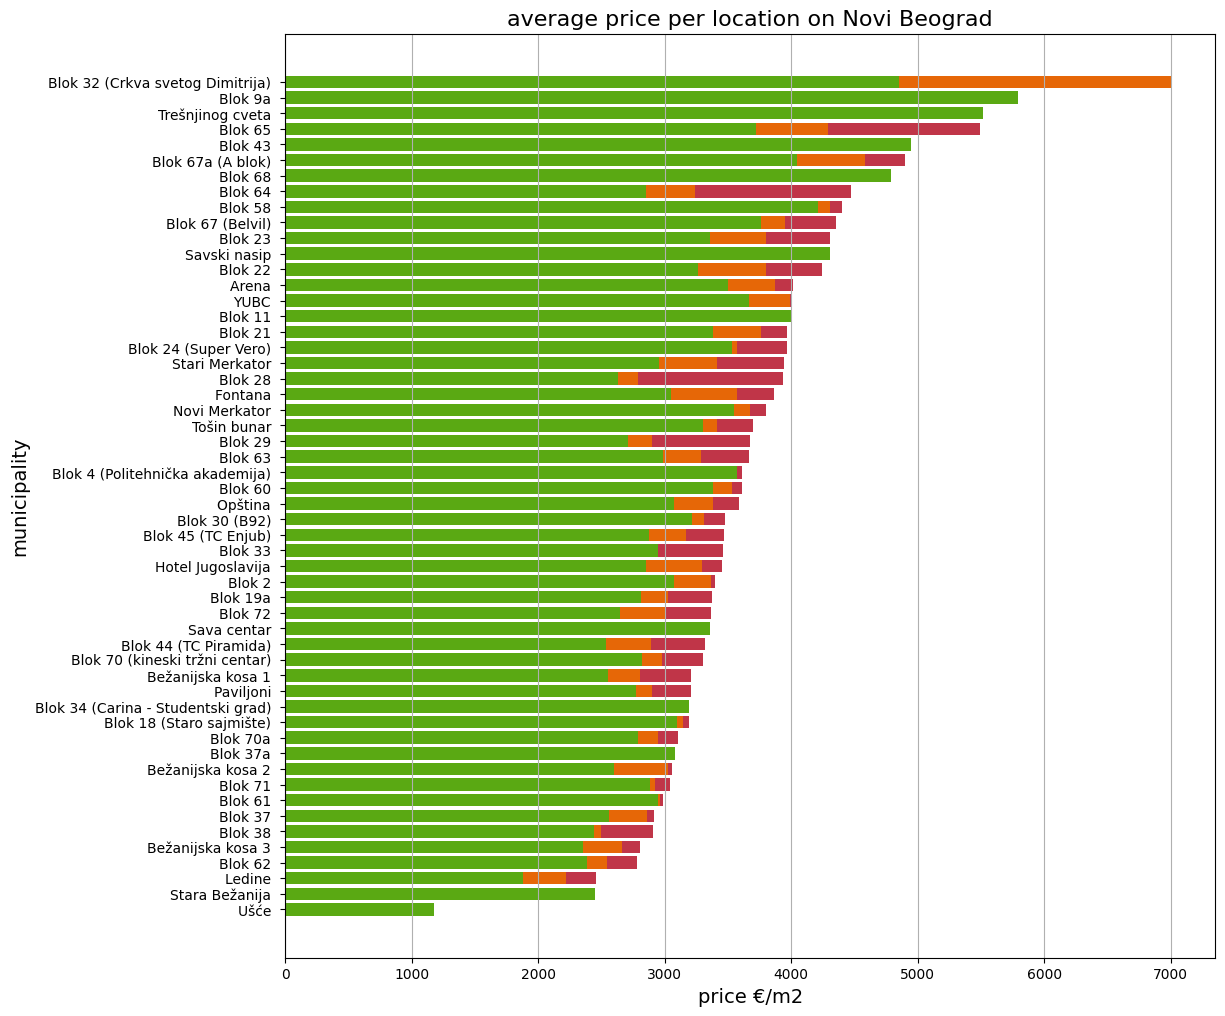

In [88]:
# average price depending of location on Novi Beograd
tmp = df[df['opstina'] == 'Novi Beograd '][['cena/m2', 'lokacija']].groupby(['lokacija'], as_index=False).quantile(0.75).sort_values(by='cena/m2',ascending=True)

plt.figure(figsize=(12, 12))
plt.grid(axis='x')
tmp = df[df['opstina'] == 'Novi Beograd '][['cena/m2', 'lokacija']].groupby(['lokacija'], as_index=False).quantile(0.75).sort_values(by='cena/m2',ascending=True)
plt.barh(tmp['lokacija'],tmp['cena/m2'],color=BAR_COLOR_3)
tmp = df[df['opstina'] == 'Novi Beograd '][['cena/m2', 'lokacija']].groupby(['lokacija'], as_index=False).median().sort_values(by='cena/m2',ascending=True)
plt.barh(tmp['lokacija'],tmp['cena/m2'],color=BAR_COLOR)
tmp = df[df['opstina'] == 'Novi Beograd '][['cena/m2', 'lokacija']].groupby(['lokacija'], as_index=False).quantile(0.25).sort_values(by='cena/m2',ascending=True)
plt.barh(tmp['lokacija'],tmp['cena/m2'],color=BAR_COLOR_2)

plt.xlabel('price €/m2', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.ylabel('municipality', fontsize=LABEL_FONT_SIZE, color=TICK_COLOR)
plt.title("average price per location on Novi Beograd", fontsize=TITLE_FONT_SIZE, color=TICK_COLOR)

plt.rc_context({'xtick.color':TICK_COLOR, 'ytick.color':TICK_COLOR,})
plt.show()